# Calculate ERA5 climatology using shifted windows

In [2]:
import os
import sys
from glob import glob
from datetime import datetime

import numpy as np
import xarray as xr

In [3]:
sys.path.insert(0, '/glade/u/home/ksha/CREDIT/libs/')
import verif_utils as vu

# Climatology calculation setup

For a given (centered) ERA5 day-of-year:

(1) We select its neighouring days with -15 and +15 days

(2) The selected days are weighted with Gaussian values (closer to the center has higher weights)

(3) The weighted sums are computed and averges to the climatology

(4) climatology are computed from 2018-2020, same as forecasts

In [4]:
# ---------------------------------------------------------------------------------------- #
# ERA5 verif target
filenames_ERA5 = sorted(glob('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/TOTAL_*'))
filenames_ERA5 = filenames_ERA5[-6:-1]

ds_ERA5 = [vu.get_forward_data(fn) for fn in filenames_ERA5]
ds_ERA5_merge = xr.concat(ds_ERA5, dim='time')
    
# Select the specified variables and their levels
variables_levels = {
    'V500': None, 
    'U500': None, 
    'T500': None, 
    'Q500': None, 
    'Z500': None,
    'SP': None, 
    't2m': None,}

ds_ERA5_merge = vu.ds_subset_everything(ds_ERA5_merge, variables_levels)
ds_ERA5_merge = ds_ERA5_merge.rename({'latitude':'lat','longitude':'lon'})

In [6]:
# Example usage
days_before = 15
days_after = 15
width = 10.0

# Compute ERA5 climatology on 12Z each day
center_hours = np.array([0, 6, 12, 18]) # 6-hourly climatology only 

save_name_prefix = '/glade/campaign/cisl/aiml/ksha/CREDIT/gathered/ERA5_climo/ERA5_DOY{:05}_HOD{:02}.nc'

## Scenario: run & skip existing files

In [11]:
for center_hour in center_hours:
    
    for doy in range(1, 3):
        save_name = save_name_prefix.format(doy, center_hour)
    
        if os.path.exists(save_name):
            print('Skip {}'.format(save_name))
        else:
            print('Starting on day-of-year: {}; hour-of-day: {}'.format(doy, center_hour))
            
            doy_range = vu.get_doy_range(doy, days_before, days_after)
            ds_ERA5_doy = vu.select_doy_range(ds_ERA5_merge, doy_range)
            ds_ERA5_clim = vu.weighted_temporal_sum(ds_ERA5_doy, doy, center_hour, width, variables_levels.keys())
            
            ds_ERA5_clim.to_netcdf(save_name)
            print('Save to {}'.format(save_name))

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

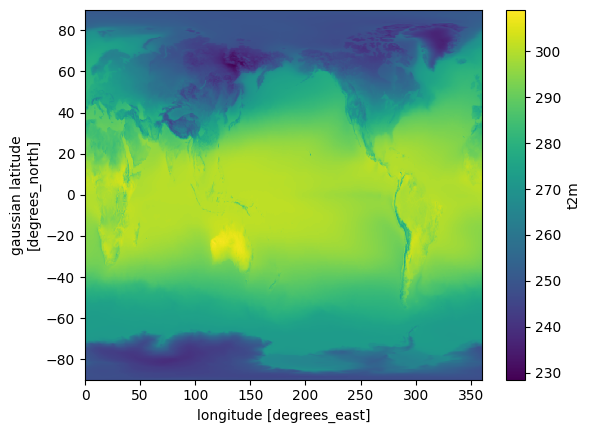

In [8]:
ds_ERA5_clim['t2m'].plot()
plt.show()